In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, ELU, Sequential, Conv1d, MaxPool1d, Module, BatchNorm1d, AvgPool1d, Dropout
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, AvgPool2d
import torch.nn.functional as F
import torch.optim as optim

import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import find_peaks

from utils import *
from CNNRES_Monitor_Dilated3_hrrr import CNNRES_Monitor_Dilated3

In [2]:
# Where the tensor is saved
tensor_dir = '/TENSOR_DIR'

# Make sure to run on GPU

In [2]:
# For reproducibility
torch.manual_seed(1234)

# Detect if we have a GPU available
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")
else:
    print("Using CPU")

True
Using GPU


In [3]:
class generate_args:
    def __init__(self):
        self.lr = 5e-5
        self.bsz = 32
        self.seed = random.randint(1, 100)
        self.num_epoch = 200
        self.early_stop = 50
        self.only_evaluate = False
        self.dropout = 0.0
        self.decay_rate = 0.9
        self.weight_decay = 0.0005
        self.rr_weight = 1.25
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_gpu = torch.cuda.device_count()
        
args = generate_args()

# Load data

In [4]:
df = pd.read_csv('./2_use_df.csv')

print(f'Num clips: {len(df)}')

Num clips: 2732


In [5]:
biopac = torch.load(tensor_dir+'/biopac_use.pt')
biopac_peak = torch.load(tensor_dir+'/biopac_peak_use.pt')
doppler = torch.load(tensor_dir+'/doppler_use.pt')

# If previously already created biopac_peak_expand then skip the next two cells and load this in directly
# biopac_peak_expand = torch.load(tensor_dir+'/biopac_peak_expand_use.pt')

In [6]:
biopac_peak_expand = torch.zeros_like(biopac_peak)
expand_time = 50 # expand each heartbeat to 400ms
latency = -15

peaks = torch.nonzero(biopac_peak)
for [i,j] in tqdm(peaks):
    biopac_peak_expand[i,j+latency:j+expand_time+latency]=1

100%|██████████| 95413/95413 [00:04<00:00, 22962.25it/s]


In [7]:
torch.save(biopac_peak_expand, tensor_dir+'/biopac_peak_expand_use.pt')

# Amplification

In [8]:
def single_hr_cycle(target_hr, 
                    dt=1/1000, 
                    omega1=30, 
                    omega2=40, 
                    length=299):
    T = 60 / target_hr
    t = np.linspace(0, T, int(T/dt), endpoint=False)
    omega1 /= T
    omega2 /= T
    gamma = 1
    b = T/2
    c = T*1e-3
    pulse = np.exp(-(t-b)**2./c)
    g_shape = np.cos(omega1*t + gamma*np.sin(omega2*t));
    w = g_shape * pulse
    # normalize
    w = w/w.sum();
    if abs(min(w)) > abs(max(w)):
        w = -w
    n = len(w)
    if n < length:
        w1 = np.zeros(length)
        start = (length - n) // 2
        w1[start:start+n] = w
    else:
        start = (n-length)//2
        w1 = w[start:start+length]
    return torch.tensor(w1)

In [9]:
length = 199

w_40 = single_hr_cycle(40,length=length)
w_60 = single_hr_cycle(60,length=length)
w_80 = single_hr_cycle(80,length=length)
w_100 = single_hr_cycle(100,length=length)

w_filter = torch.zeros(8,2,length)
w_filter[:4,0,:] = torch.stack([w_40,w_60,w_80,w_100])
w_filter[4:,1,:] = torch.stack([w_40,w_60,w_80,w_100])
w_filter = w_filter.float().to(args.device)

In [10]:
def w_filter_conv(iq):
    iq_conv = F.conv1d(iq.view(1,2,iq.shape[1]),w_filter,padding=w_filter.shape[2]//2).squeeze()
    iq = torch.cat([iq,iq_conv])
    return iq

In [11]:
class BiopacDataset_NCC(Dataset):
    def __init__(self, biopac, biopac_peak_expand, doppler):
        self.biopac = biopac
        self.biopac_peak = biopac_peak_expand
        self.doppler = doppler
        
        self.bp_fs = 250
        self.dp_fs = 1000
        
        self.seconds = 15
        
        self.seg_n = 10
        self.clip_n = biopac.shape[0]
        
        self.generator = torch.Generator().manual_seed(42)
        self.start_idx = torch.randint(0,self.doppler.shape[2]-self.seconds*self.dp_fs,(self.clip_n * self.seg_n,1),generator=self.generator)

    def __len__(self):
        return int(self.clip_n * self.seg_n)

    def __getitem__(self, idx):
        biopac_idx = idx // self.seg_n
        seg_idx = self.start_idx[idx]
        biopac_seg_idx = seg_idx // 4
        
        dp_idx = idx // self.seg_n
        dp = self.doppler[dp_idx,:,seg_idx:seg_idx+self.dp_fs*self.seconds]
                
        bp_original = self.biopac[biopac_idx, biopac_seg_idx:biopac_seg_idx+self.bp_fs*self.seconds]
        bp_peak = self.biopac_peak[biopac_idx, biopac_seg_idx:biopac_seg_idx+self.bp_fs*self.seconds]
        bp = bp_peak[::25].to(device)
        
        dp = dp.view(2,self.dp_fs*self.seconds).to(device)
        
        # rule out power resets
        dp[dp>1900] = 0
        
        # make data positive
        for i in [0,1]:
            dp[i] = dp[i] - dp[i].min()
        dp = dp / 100
            
        # cross correlation with standard pulse shape
        dp_conv = F.conv1d(dp.unsqueeze(0),w_filter,padding=w_filter.shape[2]//2).squeeze()
        dp_conv = torch.cat([dp,dp_conv]).to(device)
        
        # return data as a list
        return [dp_conv, bp, bp_original, biopac_idx]

# Encoder decoder

In [12]:
class Trainer_bin:
    def __init__(self, model, hr, hr_peak, dp, model_name):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.df = df

        self.dataset = BiopacDataset_NCC(hr, hr_peak, dp)
        n = len(hr)
        split = [0.8, 0.1, 0.1]

        split_n = lambda x,n: [int(x[0]*n), n-int(x[2]*n)]
        split = split_n(split,n)
        print('Train, validation, test split: ', split)
        generator1 = torch.Generator().manual_seed(42)
        idx = torch.randperm(len(hr_rr),generator=generator1)
        self.train_set = self.RadarDataset(hr[idx[:split[0]]],hr_peak[idx[:split[0]]], dp[idx[:split[0]]])
        self.val_set = self.RadarDataset(hr[idx[split[0]:split[1]]],hr_peak[idx[split[0]:split[1]]], dp[idx[split[0]:split[1]]])
        self.test_set = self.RadarDataset(hr[idx[split[1]:]],hr_peak[idx[split[1]:]], dp[idx[split[1]:]])
        
        self.train_loss = []
        self.val_loss = []
        self.train_MSE = []
        self.val_MSE = []
        self.train_acc = []
        self.val_acc = []
        self.model_name = model_name
        self.save_dir ='./model'
        self.epoch_count = 0
        self.criterion = nn.BCEWithLogitsLoss(reduction='sum')
        self.best_epoch = 0
        self.threshold = 0.5

    def train(self, 
              batch_size=64, 
              num_epochs=10, 
              learning_rate=0.001, 
              early_stop=50, 
              threshold=0.5, 
              start_epoch=None, 
              weight_decay=0
             ):
        
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=20, gamma=0.9)
        
        if start_epoch != None:
            self.epoch_count = start_epoch
        
        train_loader = DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)

        for epoch in range(self.num_epochs):
            self.model.train()
            train_loss = 0.0
            train_MSE = 0.0
            train_acc = 0.0
            train_baseline = 0.0
            
            print(f"Epoch {self.epoch_count}")
            val_loss, val_acc, val_baseline = self.evaluate(val_loader)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            print(f"Val Loss: {val_loss:.4f}, Val acc: {val_acc:.4f}, Baseline: {1-val_baseline:.4f}")
            
            if val_acc == max(self.val_acc):
                self.save_model(self.epoch_count)
                self.best_epoch = self.epoch_count
            if self.epoch_count - self.best_epoch > early_stop:
                return

            for (iq,hr,_,_) in tqdm(train_loader, desc=f"Epoch {self.epoch_count+1}", total=len(train_loader)):
                
                self.optimizer.zero_grad()
                outputs = self.model(iq).squeeze().float()
                loss = self.criterion(outputs, hr.float())
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                
                outputs = torch.sigmoid(outputs)>= self.threshold
                train_acc += (outputs == hr).sum().item() / hr.shape[1]
                
                train_baseline += hr.sum().item() / hr.shape[1]
                
            train_loss /= len(self.train_set)
            train_acc /= len(self.train_set)
            train_baseline /= len(self.train_set)
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            self.lr_scheduler.step()
            self.epoch_count += 1
            
            print(f"Train Loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Baseline: {1-train_baseline:.4f}")

    def evaluate(self, data_loader):
        self.model.eval()
        val_loss = 0.0
        val_MSE = 0.0
        val_acc = 0.0
        baseline = 0.0

        with torch.no_grad():
            for (iq,hr,_,_) in tqdm(data_loader, desc=f"Evaluating...", total=len(data_loader)):

                outputs = self.model(iq).squeeze().float()
                loss = self.criterion(outputs, hr.float())
                val_loss += loss.item()
                
                outputs = torch.sigmoid(outputs)>= self.threshold
                val_acc += (outputs == hr).sum().item() / hr.shape[1]
                baseline += hr.sum().item() / hr.shape[1]
                
        val_loss /= len(data_loader.dataset)
        val_acc /= len(data_loader.dataset)
        baseline /= len(data_loader.dataset)

        return val_loss, val_acc, baseline

    def save_model(self, epoch):
        save_path = os.path.join(self.save_dir, f"{self.model_name}.pt")
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved at {save_path}, Epoch {epoch}.")
        
    def calc_confusion(self, data_loader):
        self.model.eval()
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        with torch.no_grad():
            for (iq,hr,_,_) in tqdm(data_loader, desc=f"Calculating confusion matrix...", total=len(data_loader)):

                outputs = self.model(iq).squeeze().float()
                outputs = torch.sigmoid(outputs)>= self.threshold
                TP += ((outputs == hr) & (hr == 1)).sum().item()
                FP += ((outputs != hr) & (hr == 0)).sum().item()
                TN += ((outputs == hr) & (hr == 0)).sum().item()
                FN += ((outputs != hr) & (hr == 1)).sum().item()

        return {'TP':TP, 'FP':FP, 'TN':TN, 'FN':FN}
    
    def approx_correct(self, data_loader):
        self.model.eval()
        total_peaks = 0
        num_peaks_diff = 0
        within_window = 0

        with torch.no_grad():
            for (iq,hr,_,_) in tqdm(data_loader, desc=f"Checking peaks...", total=len(data_loader)):

                outputs = self.model(iq).squeeze().float()
                outputs = torch.sigmoid(outputs)>= self.threshold
                for i in range(outputs.shape[0]):
                    hr_peaks = find_peaks(hr[i].cpu(),distance=2)[0]
                    output_peaks = find_peaks(outputs[i].cpu(),distance=2)[0]
                    total_peaks += len(hr_peaks)
                    num_peaks_diff += np.abs(len(hr_peaks) - len(output_peaks))
                    for j in hr_peaks:
                        if j in output_peaks:
                            within_window += 1
                        elif j+1 in output_peaks:
                            within_window += 1
                        elif j-1 in output_peaks:
                            within_window += 1
        
        num_peaks_diff /= len(data_loader.dataset)
        within_window /= total_peaks
        
        return {'total_peaks':total_peaks, 'num_peak_diff': num_peaks_diff, 'within_3ms':within_window}

In [13]:
class EncoderDecoderRadarModel(nn.Module):
    def __init__(self, resnet, num_input_channels, num_output_channels):
        super(EncoderDecoderRadarModel, self).__init__()
        
        # Encoder: 1D ResNet-18
        self.resnet = resnet
        
        # Decoder: Upsampling layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Dropout(0.2),
            nn.Linear(3744, 150)
        ).to(torch.float)
    
    def forward(self, inp_comb):
        x = self.resnet.conv1_layers(inp_comb)
        x = self.resnet.conv2_layers(x)
        x1 = x
        x = self.resnet.conv5_32(x)
        x = self.resnet.conv32to64(self.resnet.maxpool2(self.resnet.batch32(self.resnet.conv5_32(x)+x1)))
        x2 = x
        x = self.resnet.conv5_64(x)
        x = self.resnet.conv64to128(self.resnet.maxpool2(self.resnet.batch64(self.resnet.conv5_64(x)+x2)))
        x3 = x 
        x = self.resnet.conv3_128(x)
        x = self.resnet.conv128to256(self.resnet.maxpool2(self.resnet.batch128(self.resnet.conv3_128(x)+x3)))
        x4 = x
        x = self.resnet.conv3_256(x)
        x = self.resnet.conv256to512(self.resnet.maxpool2(self.resnet.batch256(self.resnet.conv3_256(x)+x4)))
        x5 = x 
        x = self.resnet.conv3_512(x)
        x = self.resnet.conv512to1024(self.resnet.maxpool2(self.resnet.batch512(self.resnet.conv3_512(x)+x5)))
        x6 = x 
        x = self.resnet.conv3_1024(x)
        x = self.resnet.batch1024(self.resnet.conv3_1024(x)+x6)
                
        # Decoder forward pass
        output = self.decoder(x)
        return output

In [14]:
now = datetime.now()
now = now.strftime("%m%d%H%M%S")
print('Time: ',now)

model_ed = EncoderDecoderRadarModel(CNNRES_Monitor_Dilated3(args, args.device, in_channels=10), 2, 150)
model_ed.load_state_dict(torch.load('./model/encoder_decoder_best.pt'))
trainer_ed = Trainer_bin(model_ed, biopac, biopac_peak_expand, doppler,  f'encoder_decoder_{now}')

Time:  0811002547
Train, validation, test split:  [21856, 2732, 2732]


In [ ]:
trainer_ed.train(batch_size=32, 
                  num_epochs=1000, 
                  learning_rate=5e-6, 
                  early_stop=50, 
                  threshold=0.5, 
                  weight_decay=5e-3
                 )

In [16]:
_, train_acc, _ = trainer_ed.evaluate(DataLoader(trainer_ed.train_set, batch_size=32))
_, val_acc, _ = trainer_ed.evaluate(DataLoader(trainer_ed.val_set, batch_size=32))
_, test_acc, _ = trainer_ed.evaluate(DataLoader(trainer_ed.test_set, batch_size=32))

Evaluating...: 100%|██████████| 86/86 [00:03<00:00, 23.06it/s]


In [17]:
print(f'Train acc: {train_acc}')
print(f'Val acc: {val_acc}')
print(f'Test acc: {test_acc}')

Train acc: 0.9999740727183992
Val acc: 0.8849633967789164
Test acc: 0.8872205954123963


In [18]:
train_cm = trainer_ed.calc_confusion(DataLoader(trainer_ed.train_set, batch_size=32))
val_cm = trainer_ed.calc_confusion(DataLoader(trainer_ed.val_set, batch_size=32))
test_cm = trainer_ed.calc_confusion(DataLoader(trainer_ed.test_set, batch_size=32))

Calculating confusion matrix...: 100%|██████████| 86/86 [00:03<00:00, 22.95it/s]


In [19]:
print(train_cm)
print(val_cm)
print(test_cm)

{'TP': 763747, 'FP': 43, 'TN': 2514568, 'FN': 42}
{'TP': 66550, 'FP': 18510, 'TN': 296108, 'FN': 28632}
{'TP': 66664, 'FP': 18154, 'TN': 296919, 'FN': 28063}


In [20]:
def calc_precision(cm):
    return cm['TP']/(cm['TP']+cm['FP'])
def calc_recall(cm):
    return cm['TP']/(cm['TP']+cm['FN'])
def calc_f1(cm):
    precision = calc_precision(cm)
    recall = calc_recall(cm)
    return 2/(1/precision + 1/recall)


In [21]:
for cm in [train_cm, val_cm, test_cm]:
    print(f'Precision: {calc_precision(cm)*100:.2f}%, recall: {calc_recall(cm)*100:.2f}%, f1: {calc_f1(cm)*100:.2f}%')

Precision: 99.99%, recall: 99.99%, f1: 99.99%
Precision: 78.24%, recall: 69.92%, f1: 73.85%
Precision: 78.60%, recall: 70.37%, f1: 74.26%


In [22]:
# train_cm = trainer_ed.calc_confusion(DataLoader(trainer_ed.train_set, batch_size=32))
# val_cm = trainer_ed.calc_confusion(DataLoader(trainer_ed.val_set, batch_size=32))
test_cm = trainer_ed.approx_correct(DataLoader(trainer_ed.test_set, batch_size=32))

Checking peaks...: 100%|██████████| 86/86 [00:04<00:00, 18.15it/s]


In [23]:
test_cm

{'total_peaks': 46348,
 'num_peak_diff': 1.136896046852123,
 'within_3ms': 0.8742124795028912}

In [24]:
for i in range(1000,2700):
    idx = trainer_ed.test_set[i][3]
    action = df.loc[idx,'action_clean']
    if action == 'Walk in circle':
        break

In [25]:
i

1048

Lie


(0.0, 15.0)

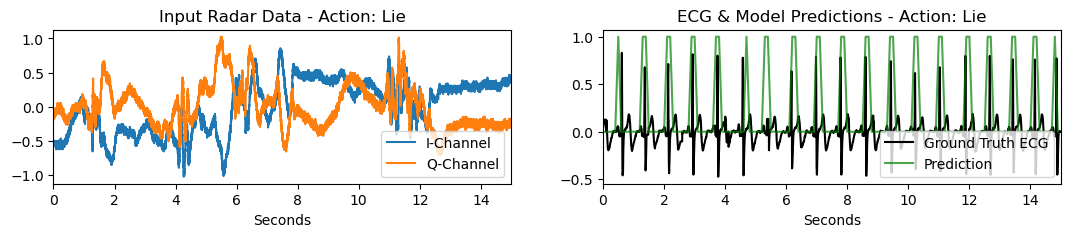

In [26]:
model_ed.eval()
i = 100

target = trainer_ed.test_set[i][1]
target_bp = trainer_ed.test_set[i][2]

with torch.no_grad():
    datapoint = trainer_ed.test_set[i][0].unsqueeze(0)
    idx = trainer_ed.test_set[i][3]
    action = df.loc[idx,'action_clean']
    print(action)
    pred = model_ed(datapoint)
    pred = torch.sigmoid(pred)
    
fig,ax=plt.subplots(1,2,figsize=(13,2))

# ax[0].plot(np.arange(0,15,1/250),target_bp, label='Original ECG', color='black')
ax[0].plot(np.arange(0,15,1/1000),(datapoint[0,0]-datapoint[0,0].mean()).cpu(),label='I-Channel')
ax[0].plot(np.arange(0,15,1/1000),(datapoint[0,1]-datapoint[0,1].mean()).cpu(),label='Q-Channel')
ax[0].legend(loc='lower right');
ax[1].plot(np.arange(0,15,1/250),target_bp, label='Ground Truth ECG', color='black')
# ax[1].plot(np.arange(0,15,1/10),target.cpu(),label='Label')
ax[1].plot(np.arange(0,15,1/10),pred[0,0].cpu()>0.5,label='Prediction', color='green', alpha=0.7)
ax[1].legend(loc='lower right')
ax[0].set_title(f'Input Radar Data - Action: {action}')
ax[1].set_title(f'ECG & Model Predictions - Action: {action}')
ax[0].set_xlabel('Seconds')
ax[1].set_xlabel('Seconds')
ax[0].set_xlim(0,15)
ax[1].set_xlim(0,15)

In [28]:
actions = df['action_clean'].unique()
actions_count = {action: 0 for action in actions}
actions_correct = {action: 0 for action in actions}

In [29]:
for i in tqdm(range(len(trainer_ed.test_set))):

    target = trainer_ed.test_set[i][1]
    target_bp = trainer_ed.test_set[i][2]

    with torch.no_grad():
        datapoint = trainer_ed.test_set[i][0].unsqueeze(0)
        idx = trainer_ed.test_set[i][3]
        action = df.loc[idx,'action_clean']
        pred = model_ed(datapoint)
        pred = torch.sigmoid(pred) > 0.5
        actions_count[action] += 1
        acc = (pred == target).float().mean()
        actions_correct[action] += acc

100%|██████████| 2732/2732 [00:31<00:00, 86.06it/s]


In [30]:
actions_acc = {}
for action in actions:
    actions_acc[action] = actions_correct[action].item() / actions_count[action]
    
actions_acc = sorted(actions_acc.items(), key=lambda x:x[1])
actions = [action[0] for action in actions_acc]
actions_acc = [action[1] for action in actions_acc]

In [32]:
actions = ['Unknown',
 'Walk\nin circle',
 'Stand',
 'Sit to\nStand',
 'Walk\nin Place',
 'Sit',
 'Jump',
 'Crouch',
 'Lie',
 'Lie with\nBlanket']

Text(0.5, 1.0, 'Test set accuracy across different actions')

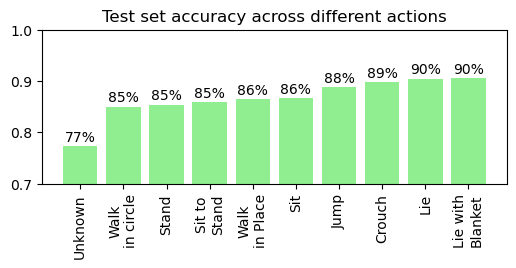

In [33]:
fig,ax = plt.subplots(figsize=(6,2))

ax.bar(actions,actions_acc,color='lightgreen')
plt.xticks(rotation=90)
for i in range(len(actions_acc)):
    ax.text(i, actions_acc[i]+0.01, str(int(actions_acc[i]*100))+'%', ha = 'center')
ax.set_ylim(0.7,1)
ax.set_title('Test set accuracy across different actions')